In [243]:
import scipy.io
import numpy as np
from scipy.optimize import minimize,fmin_cg
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### HandWritten Digit Recognition with Machine Learning

In this Notebook i implemented an Artificial Neural Network Algorithim and Trained the Model to recongnize Hand Written digits

- The Dataset used was Programmed in Matlab and Consists of 5000 Training Samples 

- The Features X repersent 20X20 Pixels images of each digit from 0-9

- The Labels y repersent the Corrsponding digit Label for each Feature in X

- The Neural Network We will implment is shown in the Follwing Figure , it has 3 Layers (One Input, A Hidden Layer, Output  Layer) (Theta1,Theta2) is The Network Weights and g(z) is The Sigmoid Function Used To repersent Our Hypothesis h0(X)

- The (a) parameters are The Activations of each Layers and a0 is bias term

![](data/neural_network.png)

## Loading Handwritten Digits Data from Matlab Matrix 

In [244]:
data = scipy.io.loadmat('data/data.mat')
#  training data stored in arrays X, y
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

#Weights is inital Weights Trained in matlab and is used at first to test our CostFunction
weights = scipy.io.loadmat('data/weights.mat') # Weights Loading 

# Setup the parameters 
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

### Data Visualization

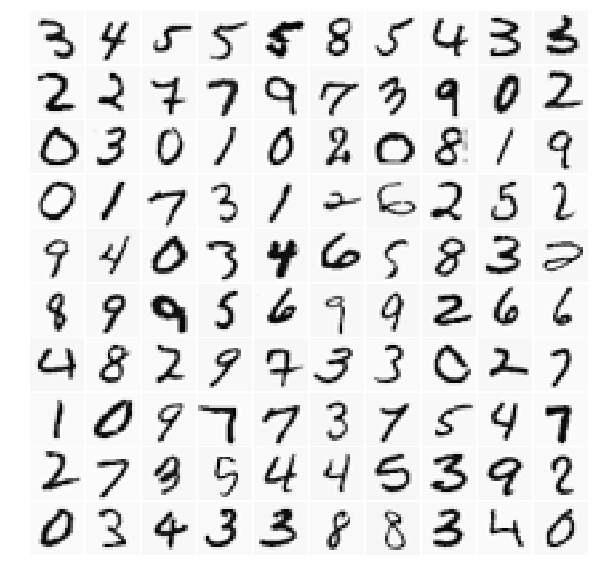

In [245]:
def displayData(X, example_width=None, figsize=(10, 10)):

    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')
        
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

### Sigmoid Convex Function Used To Repersent Model Hypothesis

In [246]:
def sigmoid(z):
	#Function used for Hypothesis repersentation for Logistic Reg
	g = 1/(1 + np.exp(-z))
	return g

### SIGMOIDGRADIENT returns the gradient of the sigmoid function

In [247]:
def sigmoidGradient(z):
    g = np.zeros(z.shape)
    g = sigmoid(z)*(1-sigmoid(z))
    
    return g

### Neural Network CostFunction
- The Cost Function J is a Measure of the diffrence between the Model Prediction and The Actual Label in y

- The Follwing Function Computes The Cost J and The Gradient of the Cost J        

- Feedforward of the neural network returns the cost J      

- Backpropagation algorithm is used to compute the gradients



In [248]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, C=0.0):
   
        
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = y.size
         
    Theta1_grad = np.zeros(Theta1.shape) #Grad Init
    Theta2_grad = np.zeros(Theta2.shape)

    #FeedForward TO Compute J
    a1 = np.c_[np.ones((m, 1)), X]  #input activations 
    
    a2 = sigmoid(a1.dot(Theta1.T))  # activations of the hidden layers
    a2 = np.c_[np.ones((a2.shape[0], 1)), a2]
    
    a3 = sigmoid(a2.dot(Theta2.T)) #output 
    
    y_matrix = np.eye(num_labels)[y] #has 10 diffrent class with zeroes all the way and one in ith position of the label
                                            #example label 3 has 1 in the third position and rest are zeros
    
    t1 = Theta1
    t2 = Theta2
    
    # Add regularization term
    
    reg = (C / (2 * m)) * (np.sum(np.square(t1[:, 1:])) + np.sum(np.square(t2[:, 1:])))
    
    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg #Cost Function J
        
    # Backpropogation
    
    delta3 = a3 - y_matrix
    delta2 = delta3.dot(Theta2)[:,1:] * sigmoidGradient(a1.dot(Theta1.T))
    Theta1_grad = Theta1_grad + delta2.T.dot(a1)
    Theta2_grad = Theta2_grad + delta3.T.dot(a2)
    
    Theta1_grad = (1/m) * Theta1_grad
    Theta1_grad[:,1:] = Theta1_grad[:,1:] + ((C/m) * Theta1_grad[:,1:])
    Theta2_grad = (1/m) * Theta2_grad
    Theta2_grad[:,1:] = Theta2_grad[:,1:] + ((C/m) * Theta2_grad[:,1:])    

    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad

In [249]:
C = 0 # Regularization Parameter

In [250]:
J,_ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, C)
print('Cost at Weights Loaded with No Regularization is = {}'.format(J))


Cost at Weights Loaded with No Regularization is = 0.2876291651613189


In [251]:
C = 1
J,_ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, C)

print('Cost at Weights Loaded with Regularization is = {}'.format(J))

Cost at Weights Loaded with Regularization is = 0.38376985909092365


### Random Initializing of the Weights

- The Weights of Our NN is Randomly initialized to Values Closer to 0

In [252]:
def randInitializeWeights(L_in, L_out):
    W = np.zeros((L_out,1 + L_in))
    eps_init = 0.12
    W = np.random.rand(L_out,1 + L_in) * 2 * eps_init - eps_init
    
    return W

In [253]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


### Gradient Checking

- The Next Section Verfies that the Previous BackPropagation implementation is Correct

- First Function Computes the gradient using Finite differences and gives us a numerical estimate of the gradient Parameters 

- Second Fucntion Creates a small neural network to check the backpropagation gradients. It will output the analytical gradients produced by The backprop code and the numerical gradients

In [254]:
def debugInitializeWeights(fan_out, fan_in):

    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W


def computeNumericalGradient(J, theta, e=1e-4):
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad


def checkNNGradients(nnCostFunction, C=0):
 
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, C)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns are very similar.')
    print('(Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If we have a correct
    # implementation,then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('backpropagation implementation is correct, \n'
          'the relative difference is (less than 1e-9). \n'
          'Relative Difference: %g' % diff)

In [255]:
checkNNGradients(nnCostFunction)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978709e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869450e-05  1.42869443e-05]
 [ 2.33146358e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468729e-04 -2.87468729e-04]
 [-1.37149709e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883257e-05  3.69883234e-05]
 [ 3.35320351e-04  3.35320347e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-6.74798369e-03 -6.74798370e-03]
 [-4.68759764e-05 -4.68759769e-05]
 [-3.76215583e-04 -3.76215587e-04]
 [-1.66560294e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.77867378e-02  5

### Minimizing The Cost Function

- In The Next Cell Scipy Optimization algorithim is Used to Find The Parameters that Minimizes Our Cost J Closer to Zero

- The Follwing Proccess is Called the Training Proccess we Use Features X and Labels y to Minimize Our Cost J

In [256]:
options= {'maxiter': 100}

C = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, C)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

### Predict Function

- The Predict Function Is Used to Predict a Label of a Given input X of Features using Our Trained Neural Network

In [257]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

### Training Accuracy Calculation

- The Predict Function is Called with Our Trained Weights and input X which was Used for The Training Proccess
- The Output Prediction is Compared to the y Values which We already have to compute Our Training Accuracy

In [258]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 95.580000


### Testing Our Neural Network Prediction

- in The Next Cell an Image from our Dataset is supplied to the the Network and using the Predict() Function The network outputs a Prediction 

- The image Supplied To the Network is plotted below and The network Prediction is Printed

- Re-run The Cell to see a Diffrent Prediction for a Different image of a Different Digit

Neural Network Prediction for This Image: 4


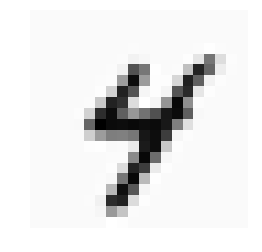

In [352]:
def Test():
    indices = np.random.permutation(m)
    if indices.size > 0:
        i, indices = indices[0], indices[1:]
        displayData(X[i, :], figsize=(4, 4))
        pred = predict(Theta1, Theta2, X[i, :])
        print('Neural Network Prediction for This Image: {}'.format(*pred))
    else:
        print('No more images to display!')
Test()

Neural Network Prediction for This Image: 2


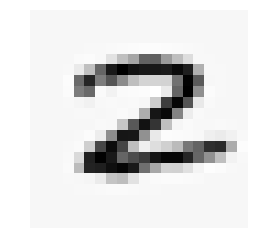

In [357]:
Test()